# analyzing dense output from distributed grid search
Tim Tyree<br>
3.27.2021

In [1]:
from lib.my_initialization import *
import cudf

In [2]:
data_folder=f'{nb_dir}/data/osg_output'
os.chdir(data_folder)
!ls

Log  Log.tar.gz  run_1_merged.csv


In [32]:
data_fn='run_1_merged.csv'
df=cudf.read_csv(data_fn)
df.drop(columns=['dt'],inplace=True)

In [33]:
#TODO: compute mean rate versus N/2 (for N even)
#TODO: plot data onto the universal curves
#TODO: load WJ's data
#TODO: plot WJ's universal curves
#TODO: compute RMSE from WJ's universal curves

In [34]:
# the set of all inputs
r_values=np.array([0.1,0.2,0.3,0.4,0.5,1.0])#cm
D_values=np.array([0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0])#cm^2/s
A_values=np.array([20.25,25,39,50,56.25,100,156.25,189])[::-1]#cm^2
L_values=np.sqrt(A_values)#cm
kappa_values=np.array([1,10,100])#1/s
print(L_values)

[13.74772708 12.5        10.          7.5         7.07106781  6.244998
  5.          4.5       ]


In [35]:
#slice data for a given condition
r=0.1;D=1.5;L=10.;kappa=10;
query=(df.r==r)&(df.D==D)&(df.L==L)&(df.kappa==kappa)
dff=df[query].copy().drop(columns=['r','D','L','kappa'])
dff['11'].size

1500

In [36]:
#extract the values
dfd=dff.describe().T.drop(columns=['count'])
# x_values=np.array([eval(x) for x in dfd.index.values])
y_values=dfd['50%'].values.copy()
yerr1_values=dfd['25%'].values.copy()
yerr2_values=dfd['75%'].values.copy()

y2_values=dfd['mean'].values.copy()
y2err1_values=y2_values-dfd['std'].values.copy()
y2err2_values=y2_values+dfd['std'].values.copy()

dfd.reset_index(inplace=True,drop=True)
dfd['N']=dfd.index.values+11
x_values=dfd.N.values

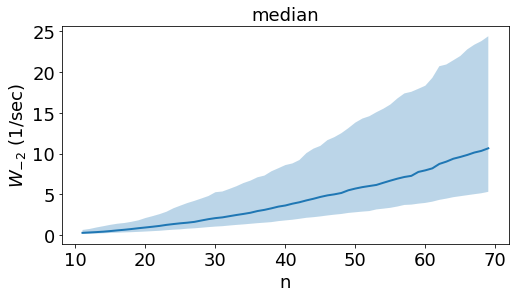

In [46]:
#plot the values
figsize=(8,4)
fontsize=18
saving=False
savefig_folder=f'{nb_dir}/../fig'
savefig_fn='collrates.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
ax.fill_between(x_values.get(),1/yerr2_values.get(),1/yerr1_values.get(),alpha=0.3)
ax.plot(x_values.get(),1/y_values.get(),lw=2)
ax.set_xlabel('n', fontsize=fontsize)
ax.set_ylabel(r'$W_{{-2}}$ (1/sec)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_title('median', fontsize=fontsize)
plt.show()

In [ ]:
#TODO: PM's logarithmic fit (see matlab) to ^that
#TODO: plot the fit over this data, and visually verify it


In [47]:
#DONE: plot rate/area versus number density 
#DONE: repeat ^that for several areas
#TODO: test for dependence on r, D, and/or kappa

In [60]:
def PlotUnivCurve(r,D,kappa):
    #plot the values
    figsize=(8,4)
    fontsize=18
    saving=True
    savefig_folder=f'{nb_dir}/data/osg_output/fig'
    savefig_fn=f'plot_r_{r}_D_{D}_k_{kappa}.png'
    fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

    for L in L_values:
        #get slice
        query=(df.r==r)&(df.D==D)&(df.L==L)&(df.kappa==kappa)
        dff=df[query].copy().drop(columns=['r','D','L','kappa'])
        #compute x,y values
        A=L**2
        dfd=dff.describe().T.drop(columns=['count'])
        y_values=1/dfd['mean'].values.copy().get()/A
        dfd.reset_index(inplace=True,drop=True)
        dfd['N']=dfd.index.values+11
        x_values=dfd.N.values.get()/A
        #plot x,y values
        ax.scatter(x_values,y_values,s=10,label=f'{A:.2f}'+r' $(cm^{-2})$')
    ax.set_xlabel(r'number density (cm$^{-2}$)', fontsize=fontsize)
    ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=0)
    ax.legend(fontsize=fontsize-6,ncol=2)
    ax.set_xlim([0,3.5])
    ax.set_ylim([0,2])
    ax.set_title(f'r={r} cm, D={D} '+r'cm$^{-2}$, $\kappa=$'+f'{kappa} Hz', fontsize=fontsize)
    fig.tight_layout()
    if not saving:
        plt.show()
    else:
        plt.tight_layout()
        os.chdir(savefig_folder)
        plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
        plt.close()
    return True

In [61]:
r=0.1;D=1.5;kappa=1;
PlotUnivCurve(r,D,kappa)

saved figure in 
	plot_r_0.1_D_1.5_k_1.png


True

__Results__
- the universal curve WJ found to be independent of area appears to be independent of area here, too.

In [63]:
# the set of all inputs
r_values=np.array([0.1,0.2,0.3,0.4,0.5,1.0])#cm
D_values=np.array([0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0])#cm^2/s
A_values=np.array([20.25,25,39,50,56.25,100,156.25,189])[::-1]#cm^2
L_values=np.sqrt(A_values)#cm
kappa_values=np.array([1,10,100])#1/s

#iterate over settings, counting the number of trials
count=0
queue = []
for r in r_values:
    for D in D_values:
        for kappa in kappa_values:
            count=count+1
            queue.append((r,D,kappa))
print(count)

144


In [64]:
def routine(item):
    r,D,kappa=item
    return PlotUnivCurve(r,D,kappa)

In [68]:
#throws MemoryError... :(
# #run plotting in parallel
# b = db.from_sequence(queue, npartitions=9).map(routine)
# start = time.time()
# retval = list(b)
# print(f"run time was {time.time()-start:.2f} seconds.")
# beep(10)

1616895802.3496983

In [69]:
#runs in series
start=time.time()
for item in queue:
    retval=routine(item)
print(f"run time was {time.time()-start:.2f} seconds.")

saved figure in 
	plot_r_0.1_D_0.25_k_1.png
saved figure in 
	plot_r_0.1_D_0.25_k_10.png
saved figure in 
	plot_r_0.1_D_0.25_k_100.png
saved figure in 
	plot_r_0.1_D_0.5_k_1.png
saved figure in 
	plot_r_0.1_D_0.5_k_10.png
saved figure in 
	plot_r_0.1_D_0.5_k_100.png
saved figure in 
	plot_r_0.1_D_0.75_k_1.png
saved figure in 
	plot_r_0.1_D_0.75_k_10.png
saved figure in 
	plot_r_0.1_D_0.75_k_100.png
saved figure in 
	plot_r_0.1_D_1.0_k_1.png
saved figure in 
	plot_r_0.1_D_1.0_k_10.png
saved figure in 
	plot_r_0.1_D_1.0_k_100.png
saved figure in 
	plot_r_0.1_D_1.25_k_1.png
saved figure in 
	plot_r_0.1_D_1.25_k_10.png
saved figure in 
	plot_r_0.1_D_1.25_k_100.png
saved figure in 
	plot_r_0.1_D_1.5_k_1.png
saved figure in 
	plot_r_0.1_D_1.5_k_10.png
saved figure in 
	plot_r_0.1_D_1.5_k_100.png
saved figure in 
	plot_r_0.1_D_1.75_k_1.png
saved figure in 
	plot_r_0.1_D_1.75_k_10.png
saved figure in 
	plot_r_0.1_D_1.75_k_100.png
saved figure in 
	plot_r_0.1_D_2.0_k_1.png
saved figure in 
	plo